# 1. Import libraries

In [421]:

# Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd


# 2. Function for converting series to supervised learning 

In [422]:
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# 3. Load the data 

In [185]:
#Load the data and data already got scaled and splited 
x_train_scaled_data=pd.read_csv('X_train_scaled_data.csv')
x_test_scaled_data=pd.read_csv('X_test_scaled_data.csv')
y_train_scaled_data=pd.read_csv('Y_train_scaled_data.csv')
y_test_scaled_data=pd.read_csv('Y_test_scaled_data.csv')

In [186]:
# declare train and test data 
x_train = x_train_scaled_data
x_test = x_test_scaled_data
y_train=y_train_scaled_data
y_test=y_test_scaled_data

In [187]:
# check the size of each dataset
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(336612, 13) (336612, 3) (84156, 13) (84156, 3)


In [192]:
#combine x train and y train as train data 
train_data=pd.DataFrame()
train_data[x_train.columns]=x_train
train_data[y_train.columns]=y_train
train_data.head()

,station,date,year,month,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,PM2.5
0,Aotizhongxin,2013-03-01 00:00:00,2013,3,0.007433,0.020671,0.020202,0.071710,0.312195,0.672185,0.339310,0.0,0.333333,4.0
1,Aotizhongxin,2013-03-01 01:00:00,2013,3,0.007433,0.020671,0.020202,0.071710,0.305691,0.675497,0.347586,0.0,0.356061,8.0
2,Aotizhongxin,2013-03-01 02:00:00,2013,3,0.009434,0.031053,0.020202,0.067974,0.305691,0.680464,0.347586,0.0,0.424242,7.0
3,Aotizhongxin,2013-03-01 03:00:00,2013,3,0.021441,0.034514,0.020202,0.067040,0.300813,0.697020,0.331034,0.0,0.234848,6.0
4,Aotizhongxin,2013-03-01 04:00:00,2013,3,0.023442,0.037974,0.020202,0.067040,0.291057,0.708609,0.329655,0.0,0.151515,3.0


In [193]:
#combine x test and y test as test data 
test_data=pd.DataFrame()
test_data[x_test.columns]=x_test
test_data[y_test.columns]=y_test
test_data.head()

,station,date,year,month,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,PM2.5
0,Aotizhongxin,2016-05-12 19:00:00,2016,5,0.003431,0.058737,0.020202,0.082916,0.653659,0.485099,0.521379,0.0,0.166667,10.0
1,Aotizhongxin,2016-05-12 20:00:00,2016,5,0.003431,0.100264,0.030303,0.061437,0.606504,0.500000,0.600000,0.0,0.045455,26.0
2,Aotizhongxin,2016-05-12 21:00:00,2016,5,0.003431,0.159092,0.040404,0.031552,0.562602,0.519868,0.620690,0.0,0.037879,11.0
3,Aotizhongxin,2016-05-12 22:00:00,2016,5,0.005432,0.214461,0.070707,0.001668,0.531707,0.529801,0.634483,0.0,0.000000,22.0
4,Aotizhongxin,2016-05-12 23:00:00,2016,5,0.005432,0.204079,0.070707,0.001668,0.505691,0.533113,0.662069,0.0,0.030303,31.0


In [425]:
# all stations name
stations=['Shunyi',
 'Tiantan',
 'Huairou',
 'Dongsi',
 'Guanyuan',
 'Changping',
 'Nongzhanguan',
 'Aotizhongxin',
 'Gucheng',
 'Wanshouxigong',
 'Dingling',
 'Wanliu']

In [405]:
# if we don't want to run this 12 times then just use train_data and test_data
# new_train_data=train_data.drop(columns=['station', 'date', 'year', 'month'])
# new_test_data=test_data.drop(columns=['station', 'date', 'year', 'month'])

In [359]:
# to run each stations data 
train_df=train_data[train_data['station']==stations[11]].drop(columns=['station', 'date', 'year', 'month'])
test_df=test_data[test_data['station']==stations[11]].drop(columns=['station', 'date', 'year', 'month'])

In [406]:
#Frame as supervised learning and drop all time t columns except PM2.5
reframed_train = series_to_supervised(new_train_data, 1, 1)
reframed_test = series_to_supervised(new_test_data, 1, 1)


In [407]:
#check the length of each dataset
len(reframed_train),len(reframed_test)

(336611, 84155)

In [408]:
# split into train and test sets
train= reframed_train.values
test=reframed_test.values

In [409]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [410]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


In [411]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [412]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 336611 samples, validate on 84155 samples
Epoch 1/50
 - 12s - loss: 6349.9601 - val_loss: 3841.8079
Epoch 2/50
 - 12s - loss: 2419.8713 - val_loss: 2040.9290
Epoch 3/50
 - 13s - loss: 1328.7501 - val_loss: 1305.8967
Epoch 4/50
 - 12s - loss: 882.2083 - val_loss: 934.1130
Epoch 5/50
 - 15s - loss: 670.0581 - val_loss: 732.6496
Epoch 6/50
 - 12s - loss: 573.6959 - val_loss: 654.6700
Epoch 7/50
 - 12s - loss: 530.0843 - val_loss: 599.9107
Epoch 8/50
 - 11s - loss: 521.7684 - val_loss: 570.5078
Epoch 9/50
 - 11s - loss: 539.1897 - val_loss: 584.6730
Epoch 10/50
 - 11s - loss: 476.4948 - val_loss: 553.1531
Epoch 11/50
 - 11s - loss: 438.2188 - val_loss: 496.4796
Epoch 12/50
 - 12s - loss: 442.0585 - val_loss: 512.8734
Epoch 13/50
 - 11s - loss: 430.6969 - val_loss: 535.3131
Epoch 14/50
 - 11s - loss: 429.4755 - val_loss: 450.4784
Epoch 15/50
 - 11s - loss: 422.4406 - val_loss: 462.6156
Epoch 16/50
 - 10s - loss: 391.7432 - val_loss: 393.9675
Epoch 17/50
 - 11s - loss: 396.7006 - va

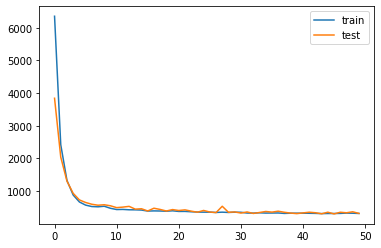

In [413]:

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 


In [414]:
# Predictions
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [415]:
import numpy as np

In [416]:
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 17.907


In [417]:
# After run 12 times for 12 different stations,
#we got the list of rmse for each station
RMSE=[31.997, 29.581, 22.482, 34.625, 30.233, 25.391,
      30.000, 28.559, 36.826, 36.191, 22.238, 27.626]
for i in range(len(stations)):
    print( 'rmse of station {} : {}'.format(stations[i],RMSE[i]))

rmse of station Shunyi : 31.997
rmse of station Tiantan : 29.581
rmse of station Huairou : 22.482
rmse of station Dongsi : 34.625
rmse of station Guanyuan : 30.233
rmse of station Changping : 25.391
rmse of station Nongzhanguan : 30.0
rmse of station Aotizhongxin : 28.559
rmse of station Gucheng : 36.826
rmse of station Wanshouxigong : 36.191
rmse of station Dingling : 22.238
rmse of station Wanliu : 27.626


In [418]:
# mean of RMSE above
RMSE_mean=np.mean(RMSE)
RMSE_mean

29.645749999999996

In [419]:
# if we don't speparate the data based on different stations and we got the total_rmse
total_rmse=17.907